<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_CatBoost_ProjTwe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Settings

### Installation

In [90]:
!pip install -q catboost shap import_ipynb dalex

### Libs

In [91]:
# utils
import os, warnings, math
import import_ipynb
import shap
import pandas as pd
import numpy as np
from copy import deepcopy
# colab
from google.colab import drive
# sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
# catboost
from catboost import *
from catboost.eval.catboost_evaluation import *
from catboost.eval.evaluation_result import *
from catboost import datasets
from catboost.utils import create_cd, get_roc_curve, get_fpr_curve, get_fnr_curve, select_threshold
# vis
import seaborn as sns
import matplotlib.pyplot as plt

### Setup

In [92]:
warnings.filterwarnings('ignore')

In [93]:
np.set_printoptions(precision=4)

In [94]:
%matplotlib inline

In [95]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [97]:
# load MachineLearningUtils module
from MachineLearningUtils import *

## Load Data

In [98]:
(train_df, test_df) = datasets.amazon()
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [99]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Save Data

In [100]:
dataset_dir = './amazon'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

train_df.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
    )
test_df.to_csv(
    os.path.join(dataset_dir, 'test.csv'),
    index=False, sep=',', header=True
    )

In [101]:
!head amazon/train.csv

ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
1,36724,14457,118219,118220,117884,117879,267952,19721,117880
1,36135,5396,117961,118343,119993,118321,240983,290919,118322
1,42680,5905,117929,117930,119569,119323,123932,19793,119325
0,45333,14561,117951,117952,118008,118568,118568,19721,118570
1,25993,17227,117961,118343,123476,118980,301534,118295,118982
1,19666,4209,117961,117969,118910,126820,269034,118638,126822
1,31246,783,117961,118413,120584,128230,302830,4673,128231


# Develop Model

In [102]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

[0, 1, 2, 3, 4, 5, 6, 7, 8]
Labels: {0, 1}
Zero count = 1897, One count = 30872


In [103]:
X.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [104]:
feature_names = dict()
for column, name in enumerate(train_df):
    if column == 0:
        continue
    feature_names[column] = name

create_cd(
    label=0,
    cat_features=list(range(1, train_df.columns.shape[0])),
    feature_names=feature_names,
    output_path=os.path.join(dataset_dir, 'train.cd')
    )

In [105]:
!cat amazon/train.cd

0	Label	
1	Categ	RESOURCE
2	Categ	MGR_ID
3	Categ	ROLE_ROLLUP_1
4	Categ	ROLE_ROLLUP_2
5	Categ	ROLE_DEPTNAME
6	Categ	ROLE_TITLE
7	Categ	ROLE_FAMILY_DESC
8	Categ	ROLE_FAMILY
9	Categ	ROLE_CODE


In [106]:
pool_obj = Pool(data=X,
             label=y,
             cat_features=cat_features
             )

# pool_obj = Pool(
#     data=os.path.join(dataset_dir, 'train.csv'),
#     delimiter=',',
#     column_description=os.path.join(dataset_dir, 'train.cd'),
#     has_header=True
#     )

# pool_obj = Pool(data=X,
#              cat_features=cat_features
#                 )

# pool_obj = Pool(
#     data=FeaturesData(
#         cat_feature_data=X.values.astype(str).astype(object),
#         cat_feature_names=list(X)
#         ),
#     label=y.values
#     )

print('Dataset shape')
print('dataset:' + str(pool_obj.shape))
print('Column names')
print('dataset:')
print(pool_obj.get_feature_names())

Dataset shape
dataset:(32769, 9)
Column names
dataset:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


In [107]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

In [108]:
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    loss_function='CrossEntropy'
    )
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
    )

print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy'}


In [109]:
model = CatBoostClassifier(
    iterations=15,
    verbose=2,
    )

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    )

Learning rate set to 0.441257
0:	learn: 0.4220777	test: 0.4223741	best: 0.4223741 (0)	total: 47.5ms	remaining: 665ms
2:	learn: 0.2621494	test: 0.2629766	best: 0.2629766 (2)	total: 148ms	remaining: 593ms
4:	learn: 0.2060274	test: 0.2019603	best: 0.2019603 (4)	total: 276ms	remaining: 553ms
6:	learn: 0.1870345	test: 0.1790904	best: 0.1790904 (6)	total: 388ms	remaining: 443ms
8:	learn: 0.1807119	test: 0.1707896	best: 0.1707896 (8)	total: 494ms	remaining: 329ms
10:	learn: 0.1762130	test: 0.1654446	best: 0.1654446 (10)	total: 578ms	remaining: 210ms
12:	learn: 0.1748232	test: 0.1642093	best: 0.1642093 (12)	total: 639ms	remaining: 98.3ms
14:	learn: 0.1733966	test: 0.1627237	best: 0.1627237 (14)	total: 726ms	remaining: 0us

bestTest = 0.162723674
bestIteration = 14



In [110]:
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
    )

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [111]:
model = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.7'
    )


model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
    )


In [112]:
model = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.01'
    )

model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
    )

In [113]:
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [114]:
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    )

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [115]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 82


In [116]:
params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1695893693
bestIteration = 38

Training on fold [1/5]

bestTest = 0.164632916
bestIteration = 48

Training on fold [2/5]

bestTest = 0.15425211
bestIteration = 35

Training on fold [3/5]

bestTest = 0.1433537051
bestIteration = 55

Training on fold [4/5]

bestTest = 0.1560519524
bestIteration = 55



In [117]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.302367,0.004317,0.302196,0.004517,0.513577,0.030360
1,1,0.227370,0.007679,0.228497,0.005126,0.642263,0.048004
2,2,0.190856,0.006917,0.196796,0.003999,0.791709,0.011361
3,3,0.178884,0.007455,0.186682,0.003242,0.813889,0.009362
4,4,0.172286,0.007957,0.181380,0.002135,0.826529,0.005319


In [118]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
    )

Best validation Logloss score, not stratified: 0.1582±0.0102 on step 53


In [119]:
cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
    )

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1614486451
bestIteration = 31

Training on fold [1/5]

bestTest = 0.1551886688
bestIteration = 56

Training on fold [2/5]

bestTest = 0.1597838545
bestIteration = 25

Training on fold [3/5]

bestTest = 0.1523066165
bestIteration = 56

Training on fold [4/5]

bestTest = 0.1577738401
bestIteration = 30

Best validation Logloss score, stratified: 0.1580±0.0041 on step 56


In [120]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
    )
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [121]:
print(model_with_early_stop.tree_count_)

30


In [122]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
    )

model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [123]:
print(model_with_early_stop.tree_count_)

30


In [124]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
    )

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
    )

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = metrics.auc(fpr, tpr)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

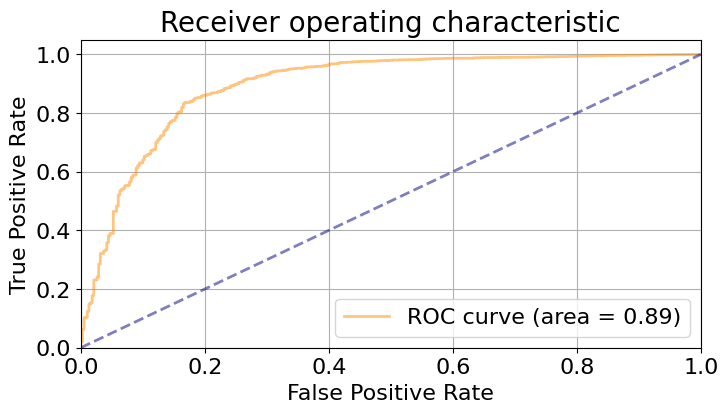

In [125]:
lw = 2
plt.figure(figsize=(8, 4))

plt.plot(fpr,
         tpr,
         color='darkorange',
         lw=lw,
         label='ROC curve (area = %0.2f)' % roc_auc,
         alpha=0.5)

plt.plot([0, 1], [0, 1],
         color='navy',
         lw=lw,
         linestyle='--',
         alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [126]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

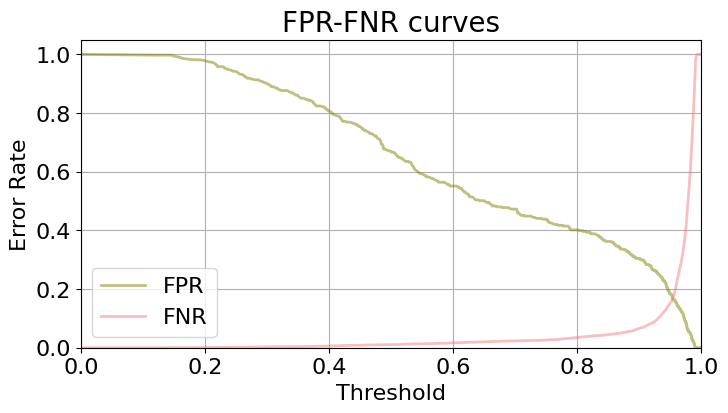

In [127]:
lw = 2
plt.figure(figsize=(8, 4))

plt.plot(thresholds,
         fpr,
         color='olive',
         lw=lw,
         label='FPR',
         alpha=0.5)

plt.plot(thresholds,
         fnr,
         color='lightcoral',
         lw=lw,
         label='FNR',
         alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [128]:
print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.4805444481363058
0.9900857295557712


In [129]:
# !rm 'catboost_info/snapshot.bkp'
model = CatBoostClassifier(
    iterations=100,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1,
    random_seed=43
    )

model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
    )

In [130]:
print(model.predict_proba(X=X_validation))

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]


In [131]:
print(model.predict(data=X_validation))

[1 1 1 ... 1 1 1]


In [132]:
raw_pred = model.predict(
    data=X_validation,
    prediction_type='RawFormulaVal'
    )

sigmoid = lambda x: 1 / (1 + np.exp(-x))
probabilities = sigmoid(raw_pred)

print(raw_pred)
print(probabilities)

[2.9282 3.9947 4.0077 ... 4.1115 4.06   3.7207]
[0.9492 0.9819 0.9821 ... 0.9839 0.983  0.9764]


In [133]:
fast_predictions = model.predict_proba(
    X=FeaturesData(
        cat_feature_data=X_validation.values.astype(str).astype(object), # FeaturesData class categorial features must have type str
        cat_feature_names=list(X_validation)
        )
    )
print(fast_predictions)

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]


In [134]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0,
    ntree_end=5,
    eval_period=1
    )

try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4154 0.5846]
 [0.4154 0.5846]
 [0.4154 0.5846]
 ...
 [0.4154 0.5846]
 [0.4154 0.5846]
 [0.4154 0.5846]]
Iteration 1, predictions:
[[0.3476 0.6524]
 [0.3476 0.6524]
 [0.3476 0.6524]
 ...
 [0.3476 0.6524]
 [0.3476 0.6524]
 [0.3476 0.6524]]
Iteration 2, predictions:
[[0.292  0.708 ]
 [0.292  0.708 ]
 [0.2978 0.7022]
 ...
 [0.2978 0.7022]
 [0.292  0.708 ]
 [0.2978 0.7022]]
Iteration 3, predictions:
[[0.2485 0.7515]
 [0.2485 0.7515]
 [0.2538 0.7462]
 ...
 [0.2538 0.7462]
 [0.2485 0.7515]
 [0.2538 0.7462]]
Iteration 4, predictions:
[[0.2126 0.7874]
 [0.2126 0.7874]
 [0.2173 0.7827]
 ...
 [0.2173 0.7827]
 [0.2126 0.7874]
 [0.2173 0.7827]]


In [135]:
model = CatBoostClassifier(
    iterations=50,
    random_seed=43,
    loss_function='MultiClass'
    )

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [136]:
def build_multiclass_ranking_dataset(X, y, cat_features, label_values=[0,1], start_group_id=0):
    ranking_matrix = []
    ranking_labels = []
    group_ids = []

    X_train_matrix = X.values
    y_train_vector = y.values

    for obj_idx in range(X.shape[0]):
        obj = list(X_train_matrix[obj_idx])

        for label in label_values:
            obj_of_given_class = deepcopy(obj)
            obj_of_given_class.append(label)
            ranking_matrix.append(obj_of_given_class)
            ranking_labels.append(float(y_train_vector[obj_idx] == label))
            group_ids.append(start_group_id + obj_idx)

    final_cat_features = deepcopy(cat_features)
    final_cat_features.append(X.shape[1]) # new feature that we are adding should be categorical
    return Pool(ranking_matrix, ranking_labels, cat_features=final_cat_features, group_id = group_ids)

In [137]:
params = {'iterations':150, 'learning_rate':0.01, 'l2_leaf_reg':30,
          'random_seed':0, 'loss_function':'QuerySoftMax'}

groupwise_train_pool = build_multiclass_ranking_dataset(X_train,
                                                        y_train,
                                                        cat_features,
                                                         [0,1]
                                                        )
groupwise_eval_pool = build_multiclass_ranking_dataset(X_validation,
                                                       y_validation,
                                                       cat_features,
                                                       [0,1],
                                                       X_train.shape[0]
                                                       )

model = CatBoost(params)
model.fit(
    X=groupwise_train_pool,
    verbose=False,
    eval_set=groupwise_eval_pool,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [138]:
obj = list(X_validation.values[0])
ratings = []
for label in [0,1]:
    obj_with_label = deepcopy(obj)
    obj_with_label.append(label)
    rating = model.predict([obj_with_label])[0]
    ratings.append(rating)
print('Raw values:', np.array(ratings))

def soft_max(values):
    return [math.exp(val) / sum([math.exp(val) for val in values]) for val in values]

print('Probabilities', np.array(soft_max(ratings)))

Raw values: [-0.471   0.4713]
Probabilities [0.2804 0.7196]


In [139]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
    )

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=50
    )
metrics = model.eval_metrics(
    data=pool_obj,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
    )

print('AUC values:')
print(np.array(metrics['AUC']))

model.get_feature_importance(prettified=True)
shap_values = model.get_feature_importance(pool_obj, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

0:	learn: 0.6569860	total: 32.1ms	remaining: 6.38s
50:	learn: 0.1923495	total: 3.36s	remaining: 9.83s
100:	learn: 0.1653594	total: 6.51s	remaining: 6.38s
150:	learn: 0.1570631	total: 9.28s	remaining: 3.01s
199:	learn: 0.1538962	total: 12.1s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

AUC values:
[0.4998 0.538  0.5504 0.5888 0.6536 0.6515 0.6476 0.648  0.7117 0.731
 0.7277 0.7278 0.7299 0.7298 0.7275 0.7273 0.7336 0.735  0.7445 0.7606
 0.7627 0.7627 0.7731 0.7769 0.7866 0.7985 0.7986 0.8008 0.8004 0.8004
 0.8191 0.8357 0.8518 0.8666 0.8851 0.8855 0.8886 0.8931 0.8936 0.8991
 0.9033 0.9115 0.9126 0.9136 0.9148 0.9163 0.9177 0.9184 0.9206 0.9211
 0.9259 0.9289 0.9291 0.9324 0.9329 0.9334 0.9338 0.9358 0.937  0.9383
 0.9386 0.9385 0.939  0.9396 0.94   0.9401 0.941  0.9411 0.942  0.9425
 0.944  0.9457 0.9471 0.9479 0.9489 0.9499 0.9512 0.9522 0.9527 0.9533
 0.9537 0.9541 0.9543 0.9547 0.955  0.9553 0.9554 0.9558 0.9558 0.9563
 0.9575 0.9584 0.9592 0.9597 0.9603 0.961  0.9614 0.9617 0.962  0.9624
 0.9627 0.963  0.9634 0.964  0.9642 0.9644 0.9648 0.9649 0.9653 0.9655
 0.9657 0.9657 0.9658 0.966  0.9661 0.9662 0.9663 0.9665 0.9665 0.9666
 0.9667 0.9669 0.967  0.9675 0.968  0.9683 0.9689 0.9694 0.9699 0.9703
 0.9706 0.9709 0.9711 0.9715 0.9715 0.9718 0.9719 0.9719 0.9723 0.

In [140]:
shap.initjs()
shap.force_plot(expected_value,
                shap_values[3,:],
                X.iloc[3,:])

In [141]:
shap.initjs()
shap.force_plot(expected_value,
                shap_values[91,:],
                X.iloc[91,:])

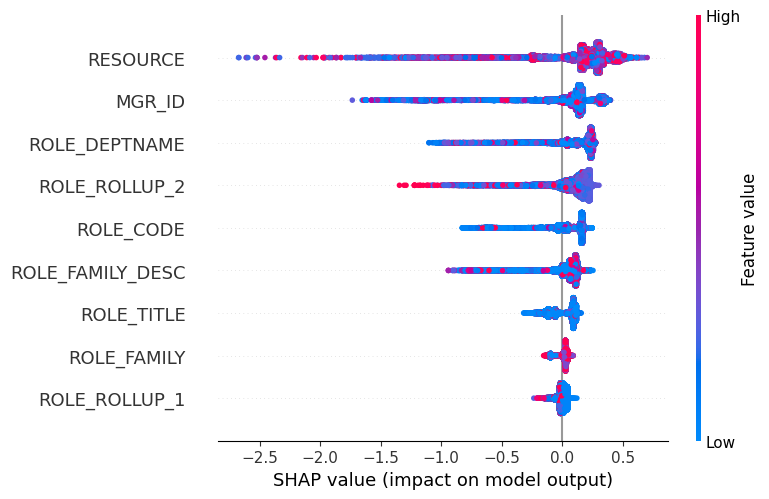

In [142]:
shap.summary_plot(shap_values, X)

In [143]:
X_small = X.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, X_small)

In [145]:
best_model = CatBoostClassifier(iterations=10)
best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
best_model.save_model('catboost_model.bin')
best_model.save_model('catboost_model.json', format='json')

best_model.load_model('catboost_model.bin')
print(best_model.get_params())
print(best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0


In [146]:
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1
    )

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True,
    )

tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    )

tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True,
    )

best_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(tunned_model.tree_count_ * 1.2),
    )

best_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=100,
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043372
0:	learn: 0.6422041	total: 34.8ms	remaining: 36.8s
100:	learn: 0.1537302	total: 5.63s	remaining: 53.4s
200:	learn: 0.1466783	total: 15s	remaining: 1m 4s
300:	learn: 0.1428331	total: 23.9s	remaining: 1m
400:	learn: 0.1389527	total: 31.6s	remaining: 51.8s
500:	learn: 0.1354927	total: 41.1s	remaining: 45.8s
600:	learn: 0.1327491	total: 48.7s	remaining: 37.1s
700:	learn: 0.1297104	total: 1m	remaining: 30.7s
800:	learn: 0.1270650	total: 1m 7s	remaining: 21.7s
900:	learn: 0.1243689	total: 1m 16s	remaining: 13.5s
1000:	learn: 0.1221292	total: 1m 26s	remaining: 5s
1058:	learn: 0.1207070	total: 1m 30s	remaining: 0us


In [147]:
X_test = test_df.drop('id', axis=1)
test_pool = Pool(data=X_test, cat_features=cat_features)
contest_predictions = best_model.predict_proba(test_pool)
print('Predictoins:')
print(contest_predictions)

Predictoins:
[[0.4144 0.5856]
 [0.0167 0.9833]
 [0.0101 0.9899]
 ...
 [0.005  0.995 ]
 [0.0446 0.9554]
 [0.0111 0.9889]]


In [148]:
f = open('submit.csv', 'w')
f.write('Id,Action\n')
for idx in range(len(contest_predictions)):
    line = str(test_df['id'][idx]) + ',' + str(contest_predictions[idx][1]) + '\n'
    f.write(line)
f.close()